In [1]:
import torch 
import numpy as np
from matplotlib import pyplot as plt
import time

from solver import Solver
from dataset import SytheticData
from model import multilayer, box_smooth

In [2]:
# Device 
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f'device={device}')

device=cuda


In [3]:
# Mesh Configurations
h = 0.01
dt = 0.001
nx = 200
nz = 100
nt = 1600
f0 = 10
t0 = 1/f0

cfl = 4 * dt / h
npw = 4 / f0 / h
print('CFL number is about' + f' {cfl:.2f}')
print('Number of grid points per wave length is about' + f' {npw:.1f}')

CFL number is about 0.40
Number of grid points per wave length is about 40.0


In [4]:
# Training configurations
num_epochs = 200
batch_size = 16
# batch_size = 8
learning_rate = 0.001
shuffle = True

In [5]:
# Sources and receivers
sx = np.arange(1, nx)
sources_xz = np.c_[np.ones_like(sx), sx]
rx = np.arange(1, nx)
receivers_xz = np.c_[2*np.ones_like(rx), rx]

In [6]:
# True model
rho, vp, vs = multilayer()

Text(0.5, 1.0, '$V_s$ in Marmousi2')

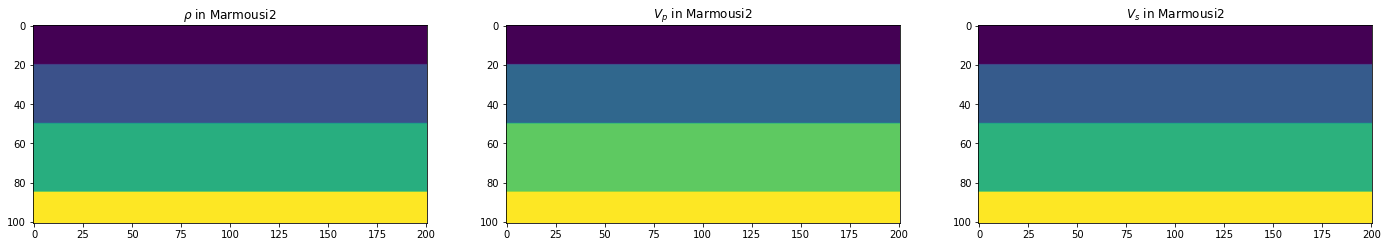

In [7]:
plt.figure(figsize=(24, 4))
plt.subplot(131)
plt.imshow(rho, aspect='equal')
plt.title(r'$\rho$ in Marmousi2')
plt.subplot(132)
plt.imshow(vp, aspect='equal')
plt.title(r'$V_p$ in Marmousi2')
plt.subplot(133)
plt.imshow(vs, aspect='equal')
plt.title(r'$V_s$ in Marmousi2')

In [8]:
print('rho in ({:.2f}, {:.2f})'.format(rho.min(), rho.max()))
print('vp in ({:.2f}, {:.2f})'.format(vp.min(), vp.max()))
print('vs in ({:.2f}, {:.2f})'.format(vs.min(), vs.max()))

rho in (1.90, 2.70)
vp in (2.00, 3.20)
vs in (1.20, 2.60)


In [9]:
# Dataset and dataloader
rho_true = torch.from_numpy(rho).to(torch.float32)
vp_true = torch.from_numpy(vp).to(torch.float32)
vs_true = torch.from_numpy(vs).to(torch.float32)
dataset = SytheticData(rho_true, vp_true, vs_true, h, dt, nt, t0, f0, sources_xz, receivers_xz)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [10]:
# Initial model
# rho_initial = box_smooth(rho_true, 40, 40).to(device)
rho_initial = rho_true.to(device)
vp_initial = box_smooth(vp_true, 40, 40).to(device)
vs_initial = box_smooth(vs_true, 40, 40).to(device)
rho_initial_numpy = rho_initial.clone().cpu().numpy()
vp_initial_numpy = vp_initial.clone().cpu().numpy()
vs_initial_numpy = vs_initial.clone().cpu().numpy()
# rho_initial.requires_grad = True
vp_initial.requires_grad = True
vs_initial.requires_grad = True

In [11]:
# Initial solver
solver_initial = Solver(rho_initial, vp_initial, vs_initial, h, dt, nt, t0, f0, receivers_xz)

In [12]:
# Loss function
criterion = torch.nn.MSELoss()

In [13]:
# Optimizer 
# all_params = [rho_initial, vp_initial, vs_initial]
all_params = [vp_initial, vs_initial]
optimizer = torch.optim.Adam(all_params, lr=learning_rate)
# optimizer = torch.optim.RMSprop(all_params, lr=learning_rate)
# optimizer = torch.optim.NAdam(all_params, lr=learning_rate)
# optimizer = torch.optim.Adamax(all_params, lr=learning_rate)
# optimizer = torch.optim.Adadelta(all_params, lr=learning_rate)
# optimizer = torch.optim.Adagrad(all_params, lr=learning_rate)

In [14]:
# Logger 
loss_list = []

In [15]:
# Training
time_begin_train = time.time()
n_batch = 0
for n_epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        n_batch += 1
        time_begin = time.time()
        sx, vx_obs, vy_obs = data 
        optimizer.zero_grad()
        vx, vy = solver_initial.step(sx)
        loss_val = criterion(vx, vx_obs.to(device)) + criterion(vy, vy_obs.to(device)) # ?
        loss_val.backward()
        loss_list.append(loss_val.item())
        optimizer.step()
        time_end = time.time()
        print(f"Epoch {n_epoch+1}, Batch {n_batch}, loss={loss_val:.6f}, time={time_end - time_begin:.2f}s")
time_end_train = time.time()
print(f'Total cost time {time_end_train - time_begin_train:.2f}s')

Epoch 1, Batch 1, loss=0.019269, time=8.59s
Epoch 1, Batch 2, loss=0.019117, time=7.32s
Epoch 1, Batch 3, loss=0.017851, time=7.18s
Epoch 1, Batch 4, loss=0.018689, time=7.09s
Epoch 1, Batch 5, loss=0.017388, time=7.72s
Epoch 1, Batch 6, loss=0.017359, time=7.28s
Epoch 1, Batch 7, loss=0.017712, time=7.32s
Epoch 1, Batch 8, loss=0.017104, time=7.32s
Epoch 1, Batch 9, loss=0.017921, time=7.26s
Epoch 1, Batch 10, loss=0.015706, time=7.65s
Epoch 1, Batch 11, loss=0.016709, time=7.28s
Epoch 1, Batch 12, loss=0.015670, time=7.27s
Epoch 1, Batch 13, loss=0.015875, time=9.79s
Epoch 2, Batch 14, loss=0.015387, time=8.39s
Epoch 2, Batch 15, loss=0.015532, time=7.79s
Epoch 2, Batch 16, loss=0.014988, time=7.27s
Epoch 2, Batch 17, loss=0.014329, time=7.88s
Epoch 2, Batch 18, loss=0.015148, time=7.80s
Epoch 2, Batch 19, loss=0.013870, time=7.37s
Epoch 2, Batch 20, loss=0.015086, time=7.28s
Epoch 2, Batch 21, loss=0.013799, time=7.29s
Epoch 2, Batch 22, loss=0.013681, time=8.24s
Epoch 2, Batch 23, 

In [16]:
rho_inversion = rho_initial.detach().cpu().numpy()
vp_inversion = vp_initial.detach().cpu().numpy()
vs_inversion = vs_initial.detach().cpu().numpy()

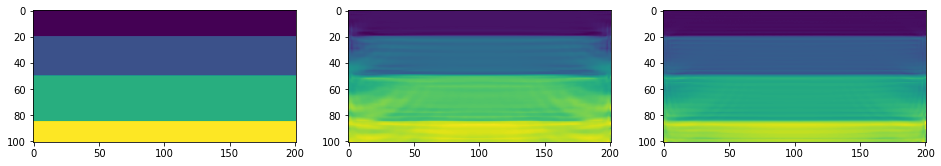

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.imshow(rho_inversion)
plt.subplot(132)
plt.imshow(vp_inversion)
plt.subplot(133)
plt.imshow(vs_inversion)

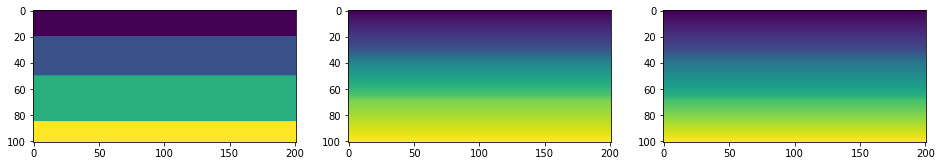

In [18]:
plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.imshow(rho_initial_numpy)
plt.subplot(132)
plt.imshow(vp_initial_numpy)
plt.subplot(133)
plt.imshow(vs_initial_numpy)

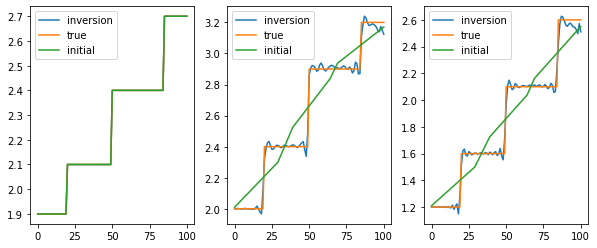

In [19]:
ncol = 100
plt.figure(figsize=(10, 4))
plt.subplot(131)
plt.plot(rho_inversion[:, ncol], label='inversion')
plt.plot(rho_true[:, ncol], label='true')
plt.plot(rho_initial_numpy[:, ncol], label='initial')
plt.legend()
plt.subplot(132)
plt.plot(vp_inversion[:, ncol], label='inversion')
plt.plot(vp_true[:, ncol], label='true')
plt.plot(vp_initial_numpy[:, ncol], label='initial')
plt.legend()
plt.subplot(133)
plt.plot(vs_inversion[:, ncol], label='inversion')
plt.plot(vs_true[:, ncol], label='true')
plt.plot(vs_initial_numpy[:, ncol], label='initial')
plt.legend()

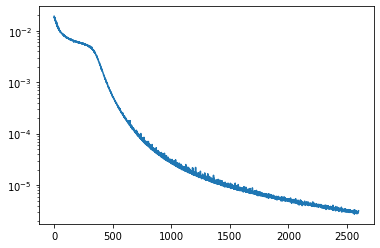

In [22]:
plt.plot(loss_list)
plt.yscale('log')

In [24]:
path = './data/multilayer_adam/'
np.save(path+'rho_true', rho)
np.save(path+'rho_initial', rho_initial_numpy)
np.save(path+'rho_inversion', rho_inversion)
np.save(path+'vp_true', vp)
np.save(path+'vp_initial', vp_initial_numpy)
np.save(path+'vp_inversion', vp_inversion)
np.save(path+'vs_true', vs)
np.save(path+'vs_initial', vs_initial_numpy)
np.save(path+'vs_inversion', vs_inversion)
np.save(path+'loss', np.array(loss_list))